In [9]:
# ‰ª•Â§™ÂùäÊ¨∫ËØàÊ£ÄÊµãÂàÜÊûêËÑöÊú¨
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [20]:
from sklearn.feature_selection import VarianceThreshold

In [10]:
# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰Ωì
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [11]:
print("=== ‰ª•Â§™ÂùäÊ¨∫ËØàÊ£ÄÊµãÂÆåÊï¥ÂàÜÊûê ===")

# ============================================================================
# 1. Êï∞ÊçÆÂä†ËΩΩÂíåÊé¢Á¥¢
# ============================================================================
print("\n1. Êï∞ÊçÆÂä†ËΩΩÂíåÊé¢Á¥¢")

=== ‰ª•Â§™ÂùäÊ¨∫ËØàÊ£ÄÊµãÂÆåÊï¥ÂàÜÊûê ===

1. Êï∞ÊçÆÂä†ËΩΩÂíåÊé¢Á¥¢


In [12]:
df=pd.read_csv('transaction_dataset.csv')

In [13]:
# ÊòæÁ§∫Âü∫Êú¨‰ø°ÊÅØ
print("\nÊï∞ÊçÆÈõÜÂü∫Êú¨‰ø°ÊÅØ:")
print(df.info())
print(f"\nÊ¨∫ËØàÊ†áÁ≠æÂàÜÂ∏É:\n{df['FLAG'].value_counts()}")
print(f"Ê¨∫ËØàÊØî‰æã: {df['FLAG'].mean():.3f}")


Êï∞ÊçÆÈõÜÂü∫Êú¨‰ø°ÊÅØ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                      

In [14]:
# ============================================================================
# 2. Êï∞ÊçÆÊ∏ÖÊ¥ó
# ============================================================================
print("\n2. Êï∞ÊçÆÊ∏ÖÊ¥ó")


2. Êï∞ÊçÆÊ∏ÖÊ¥ó


In [24]:
# Ê£ÄÊü•Áº∫Â§±ÂÄº
missing_values = df.isnull().sum()
print("Áº∫Â§±ÂÄºÁªüËÆ°:")
print(missing_values[missing_values > 0])

# Â§ÑÁêÜÁº∫Â§±ÂÄº
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Ê£ÄÊü•Êó†Á©∑ÂÄº
inf_count = np.isinf(df[numeric_columns]).sum().sum()
print(f"Êó†Á©∑ÂÄºÊï∞Èáè: {inf_count}")

# Â§ÑÁêÜÊó†Á©∑ÂÄº
df[numeric_columns] = df[numeric_columns].replace([np.inf, -np.inf], np.nan)
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Ê£ÄÊü•Âçï‰∏ÄÂÄºÁâπÂæÅÔºàÊñπÂ∑Æ‰∏∫0ÁöÑÁâπÂæÅÔºâ
print("\nÊ£ÄÊü•Âçï‰∏ÄÂÄºÁâπÂæÅ...")
single_value_features = []
for col in numeric_columns:
    if df[col].nunique() <= 1:
        single_value_features.append(col)
        print(f"Âçï‰∏ÄÂÄºÁâπÂæÅ: {col}, ÂîØ‰∏ÄÂÄº: {df[col].unique()}")

if single_value_features:
    print(f"Âà†Èô§Âçï‰∏ÄÂÄºÁâπÂæÅ: {single_value_features}")
    df = df.drop(single_value_features, axis=1)

# Ê£ÄÊü•‰ΩéÊñπÂ∑ÆÁâπÂæÅ
print("\nÊ£ÄÊü•‰ΩéÊñπÂ∑ÆÁâπÂæÅ...")
variance_threshold = VarianceThreshold(threshold=0.01)  # ÊñπÂ∑ÆÈòàÂÄº
try:
    variances = variance_threshold.fit(df[numeric_columns])
    low_variance_mask = ~variances.get_support()
    low_variance_features = df[numeric_columns].columns[low_variance_mask].tolist()
    
    if low_variance_features:
        print(f"‰ΩéÊñπÂ∑ÆÁâπÂæÅ: {low_variance_features}")
        # ÂèØ‰ª•ÈÄâÊã©Âà†Èô§Êàñ‰øùÁïôÔºåËøôÈáåÂÖàÊòæÁ§∫‰ø°ÊÅØ
        for feature in low_variance_features:
            print(f"  {feature}: ÊñπÂ∑Æ = {df[feature].var():.6f}")
except Exception as e:
    print(f"ÊñπÂ∑ÆÊ£ÄÊü•Âá∫Èîô: {e}")

# Âà†Èô§ÈùûÁâπÂæÅÂàó
columns_to_drop = ['Address', 'Index','Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)
        print(f"Âà†Èô§Âàó: {col}")

print(f"Ê∏ÖÊ¥óÂêéÊï∞ÊçÆÂΩ¢Áä∂: {df.shape}")

Áº∫Â§±ÂÄºÁªüËÆ°:
 ERC20 most sent token type    841
 ERC20_most_rec_token_type     851
dtype: int64
Êó†Á©∑ÂÄºÊï∞Èáè: 0

Ê£ÄÊü•Âçï‰∏ÄÂÄºÁâπÂæÅ...

Ê£ÄÊü•‰ΩéÊñπÂ∑ÆÁâπÂæÅ...
‰ΩéÊñπÂ∑ÆÁâπÂæÅ: ['min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total ether sent contracts', ' ERC20 uniq sent addr.1']
  min value sent to contract: ÊñπÂ∑Æ = 0.000000
  max val sent to contract: ÊñπÂ∑Æ = 0.000000
  avg value sent to contract: ÊñπÂ∑Æ = 0.000000
  total ether sent contracts: ÊñπÂ∑Æ = 0.000000
   ERC20 uniq sent addr.1: ÊñπÂ∑Æ = 0.003953
Âà†Èô§Âàó: Unnamed: 0
Ê∏ÖÊ¥óÂêéÊï∞ÊçÆÂΩ¢Áä∂: (9841, 41)


In [16]:
# ============================================================================
# 3. Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûê
# ============================================================================
print("\n3. Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûê")


3. Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûê


In [25]:
# 3.1 Âü∫Êú¨ÁªüËÆ°
fraud_stats = df[df['FLAG'] == 1].describe()
normal_stats = df[df['FLAG'] == 0].describe()

print("Ê¨∫ËØà‰∫§ÊòìÂü∫Êú¨ÁªüËÆ°:")
print(fraud_stats.loc[['mean', 'std', 'min', 'max']].T.head(8))

Ê¨∫ËØà‰∫§ÊòìÂü∫Êú¨ÁªüËÆ°:
                                                 mean            std  min  \
FLAG                                         1.000000       0.000000  1.0   
Avg min between sent tnx                  3888.109780   17505.367743  0.0   
Avg min between received tnx              2874.712639   10624.453455  0.0   
Time Diff between first and last (Mins)  55230.057953  107518.118553  0.0   
Sent tnx                                     5.173933      21.884569  0.0   
Received Tnx                                23.775585     253.953161  0.0   
Number of Created Contracts                  0.093162       0.356037  0.0   
Unique Received From Addresses              12.475906      69.380810  0.0   

                                               max  
FLAG                                          1.00  
Avg min between sent tnx                 262976.00  
Avg min between received tnx             194451.33  
Time Diff between first and last (Mins)  933778.82  
Sent tnx       


ÁªòÂà∂ÁâπÂæÅÂàÜÂ∏ÉÂõæ...
Â∞ÜË¶ÅÁªòÂà∂ÁöÑÁâπÂæÅ: ['Avg min between sent tnx', 'Unique Received From Addresses', 'Avg min between received tnx', 'Time Diff between first and last (Mins)']


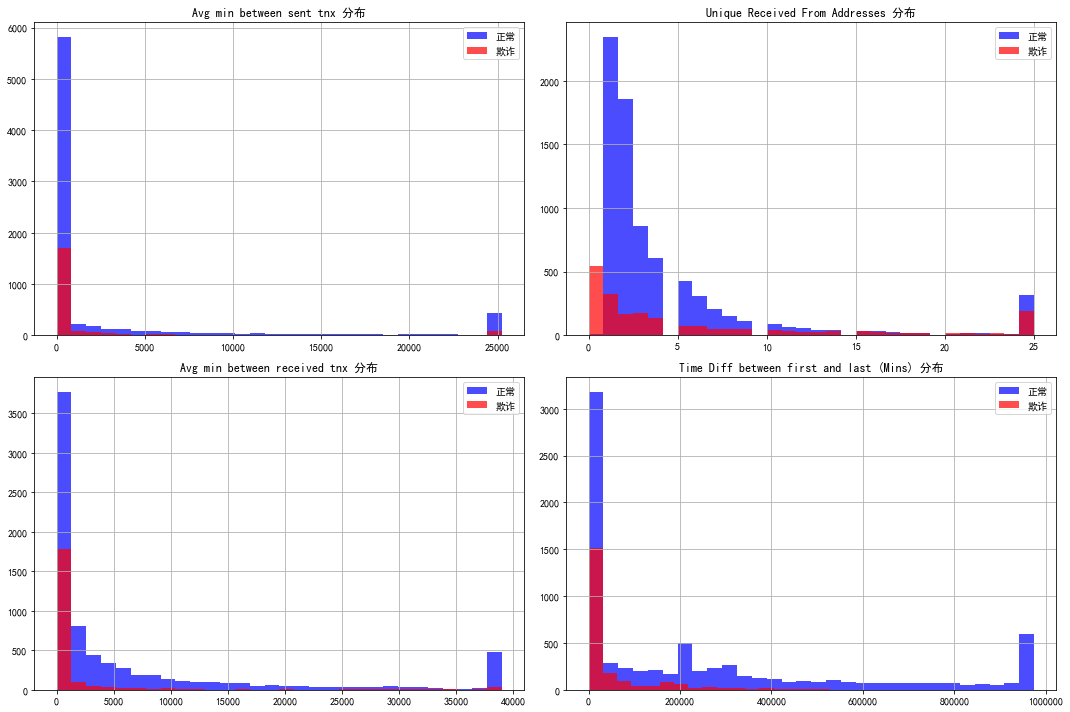

In [26]:
# 3.2 ÁâπÂæÅÂàÜÂ∏ÉÂèØËßÜÂåñÔºà‰øÆÂ§çÁ©∫ÂõæÈóÆÈ¢òÔºâ
print("\nÁªòÂà∂ÁâπÂæÅÂàÜÂ∏ÉÂõæ...")

# Âä®ÊÄÅÈÄâÊã©Â≠òÂú®ÁöÑÊï∞ÂÄºÁâπÂæÅ
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# ÁßªÈô§ÁõÆÊ†áÂèòÈáè
if 'FLAG' in numeric_features:
    numeric_features.remove('FLAG')

# ÈÄâÊã©Ââç4‰∏™Â≠òÂú®ÁöÑÁâπÂæÅËøõË°åÂèØËßÜÂåñ
features_to_plot = []
for feature in ['Sent_tnx', 'Total Ether Received', 'Avg min between sent tnx', 'Total ERC20 Tnxs', 
                'Received_tnx', 'Total Ether Sent', 'Unique Received From Addresses']:
    if feature in numeric_features and feature in df.columns:
        features_to_plot.append(feature)
    if len(features_to_plot) >= 4:
        break

# Â¶ÇÊûúÁâπÂæÅ‰∏çÂ§üÔºåÁî®ÂÖ∂‰ªñÊï∞ÂÄºÁâπÂæÅË°•ÂÖÖ
if len(features_to_plot) < 4:
    additional_features = [f for f in numeric_features if f not in features_to_plot][:4-len(features_to_plot)]
    features_to_plot.extend(additional_features)

print(f"Â∞ÜË¶ÅÁªòÂà∂ÁöÑÁâπÂæÅ: {features_to_plot}")

if len(features_to_plot) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(features_to_plot[:4]):
        if feature in df.columns:
            # Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶ÊúâÊïà
            if len(df[feature].dropna()) > 0:
                ax = axes[i]
                # ÂØπÊï∞ÊçÆËøõË°åË£ÅÂâ™ÔºåÈÅøÂÖçÊûÅÁ´ØÂÄºÂΩ±ÂìçÂèØËßÜÂåñ
                data_to_plot = df[feature].clip(upper=df[feature].quantile(0.95))
                
                normal_data_plot = data_to_plot[df['FLAG'] == 0]
                fraud_data_plot = data_to_plot[df['FLAG'] == 1]
                
                if len(normal_data_plot) > 0:
                    normal_data_plot.hist(bins=30, alpha=0.7, label='Ê≠£Â∏∏', ax=ax, color='blue')
                if len(fraud_data_plot) > 0:
                    fraud_data_plot.hist(bins=30, alpha=0.7, label='Ê¨∫ËØà', ax=ax, color='red')
                
                ax.set_title(f'{feature} ÂàÜÂ∏É')
                ax.legend()
            else:
                ax.set_title(f'{feature} (Êó†Êï∞ÊçÆ)')
                ax.text(0.5, 0.5, 'Êó†Êï∞ÊçÆ', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.set_title(f'{feature} (‰∏çÂ≠òÂú®)')
            ax.text(0.5, 0.5, 'ÁâπÂæÅ‰∏çÂ≠òÂú®', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
else:
    print("ÂèØÁî®ÁöÑÁâπÂæÅÊï∞Èáè‰∏çË∂≥ÔºåË∑≥ËøáÂàÜÂ∏ÉÂõæ")


ËøõË°åÁõ∏ÂÖ≥ÊÄßÂàÜÊûê...


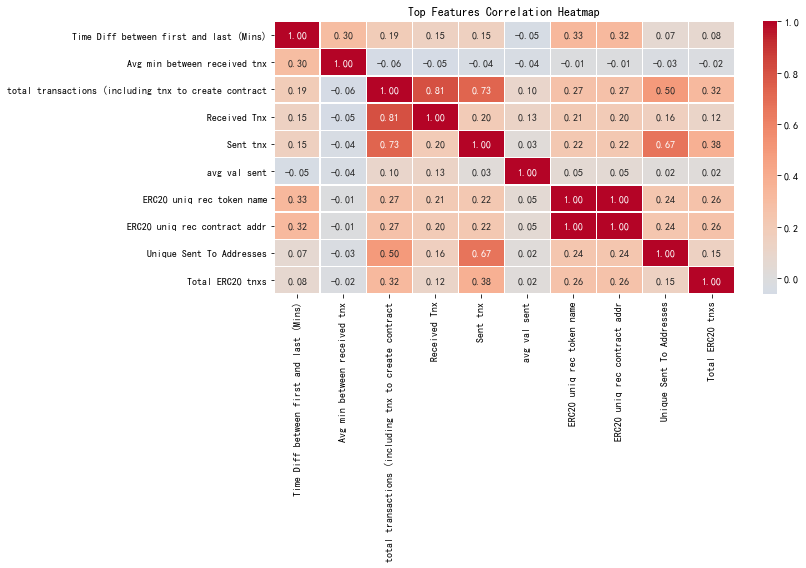


‰∏éÊ¨∫ËØàÊ†áÁ≠æÊúÄÁõ∏ÂÖ≥ÁöÑÁâπÂæÅ:
FLAG                                                    1.000000
Time Diff between first and last (Mins)                 0.269354
Avg min between received tnx                            0.118533
total transactions (including tnx to create contract    0.100289
Received Tnx                                            0.079316
Sent tnx                                                0.078006
avg val sent                                            0.063556
 ERC20 uniq rec token name                              0.052603
 ERC20 uniq rec contract addr                           0.052473
Unique Sent To Addresses                                0.045584
Name: FLAG, dtype: float64


In [27]:
# 3.3 Áõ∏ÂÖ≥ÊÄßÂàÜÊûê
print("\nËøõË°åÁõ∏ÂÖ≥ÊÄßÂàÜÊûê...")

# Á°Æ‰øùÊúâË∂≥Â§üÁöÑÊï∞ÂÄºÁâπÂæÅ
numeric_features_for_corr = df.select_dtypes(include=[np.number]).columns
if len(numeric_features_for_corr) > 1:
    plt.figure(figsize=(12, 8))
    corr_matrix = df[numeric_features_for_corr].corr()
    
    if 'FLAG' in corr_matrix.columns:
        flag_corr = corr_matrix['FLAG'].abs().sort_values(ascending=False)
        # ÈÄâÊã©‰∏éFLAGÁõ∏ÂÖ≥ÊÄßÊúÄÈ´òÁöÑÁâπÂæÅÔºàÊéíÈô§FLAGËá™Ë∫´Ôºâ
        top_features = flag_corr[flag_corr.index != 'FLAG'].head(10).index
        
        if len(top_features) > 1:
            top_corr_matrix = df[top_features].corr()
            sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
            plt.title('Top Features Correlation Heatmap')
            plt.tight_layout()
            plt.show()
            
            print("\n‰∏éÊ¨∫ËØàÊ†áÁ≠æÊúÄÁõ∏ÂÖ≥ÁöÑÁâπÂæÅ:")
            print(flag_corr.head(10))
        else:
            print("Ê≤°ÊúâË∂≥Â§üÁöÑÁõ∏ÂÖ≥ÁâπÂæÅËøõË°åÁÉ≠ÂäõÂõæÂ±ïÁ§∫")
    else:
        print("Êï∞ÊçÆÈõÜ‰∏≠Ê≤°ÊúâFLAGÂàó")
else:
    print("Êï∞ÂÄºÁâπÂæÅÊï∞Èáè‰∏çË∂≥ÔºåË∑≥ËøáÁõ∏ÂÖ≥ÊÄßÂàÜÊûê")


ÁªòÂà∂ÁâπÂæÅÂØπÊØîÁÆ±Á∫øÂõæ...


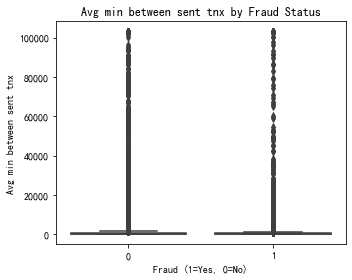

In [28]:
# 3.4 ÁâπÂæÅÂØπÊØîÁÆ±Á∫øÂõæÔºà‰øÆÂ§çÁâàÔºâ
print("\nÁªòÂà∂ÁâπÂæÅÂØπÊØîÁÆ±Á∫øÂõæ...")

# ÈÄâÊã©Â≠òÂú®ÁöÑÁâπÂæÅ
available_features = []
for feature in ['Sent_tnx', 'Received_tnx', 'Total Ether Received', 'Total Ether Sent', 'Avg min between sent tnx']:
    if feature in df.columns and df[feature].nunique() > 1:
        available_features.append(feature)

if available_features:
    n_features = len(available_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.ravel()
    else:
        axes = axes.ravel()
    
    for i, feature in enumerate(available_features):
        if i < len(axes):
            # Â§ÑÁêÜÊûÅÁ´ØÂÄºÔºåÈÅøÂÖçÁÆ±Á∫øÂõæÊòæÁ§∫ÈóÆÈ¢ò
            feature_data = df[[feature, 'FLAG']].copy()
            q99 = feature_data[feature].quantile(0.99)
            feature_data[feature] = feature_data[feature].clip(upper=q99)
            
            sns.boxplot(x='FLAG', y=feature, data=feature_data, ax=axes[i])
            axes[i].set_title(f'{feature} by Fraud Status')
            axes[i].set_xlabel('Fraud (1=Yes, 0=No)')
    
    # ÈöêËóèÂ§ö‰ΩôÁöÑÂ≠êÂõæ
    for i in range(len(available_features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
else:
    print("Ê≤°ÊúâÂèØÁî®ÁöÑÁâπÂæÅËøõË°åÁÆ±Á∫øÂõæÂ±ïÁ§∫")

In [30]:
# ============================================================================
# 4. ÁâπÂæÅÂ∑•Á®ãÔºàÂ¢ûÂº∫ÁâàÔºâ
# ============================================================================
print("\n4. ÁâπÂæÅÂ∑•Á®ã")

# ÂáÜÂ§áÁâπÂæÅÂíåÁõÆÊ†áÂèòÈáè
if 'FLAG' in df.columns:
    X = df.drop('FLAG', axis=1)
    y = df['FLAG']
else:
    print("ÈîôËØØÔºöÊï∞ÊçÆÈõÜ‰∏≠Ê≤°ÊúâFLAGÂàó")
    exit()

# Ê£ÄÊü•Âπ∂Â§ÑÁêÜÂ≠óÁ¨¶‰∏≤Âàó
print("Ê£ÄÊü•Êï∞ÊçÆÁ±ªÂûã...")
string_columns = X.select_dtypes(include=['object']).columns.tolist()
if string_columns:
    print(f"ÂèëÁé∞Â≠óÁ¨¶‰∏≤Âàó: {string_columns}")
    print("Â≠óÁ¨¶‰∏≤ÂàóÁöÑÂÄºÊ†∑‰æã:")
    for col in string_columns:
        print(f"  {col}: {X[col].unique()[:5]}")  # ÊòæÁ§∫Ââç5‰∏™ÂîØ‰∏ÄÂÄº
    
    # Â§ÑÁêÜÊñπÊ≥ï1: Âà†Èô§Â≠óÁ¨¶‰∏≤Âàó
    X = X.drop(string_columns, axis=1)
    print(f"Â∑≤Âà†Èô§Â≠óÁ¨¶‰∏≤ÂàóÔºåÂâ©‰ΩôÁâπÂæÅÊï∞Èáè: {X.shape[1]}")
    
    # ÊàñËÄÖÂèØ‰ª•‰ΩøÁî®ÊñπÊ≥ï2: ÂØπÂ≠óÁ¨¶‰∏≤ÂàóËøõË°åÁºñÁ†ÅÔºàÂ¶ÇÊûúÈúÄË¶Å‰øùÁïôËøô‰∫õÁâπÂæÅÔºâ
    # from sklearn.preprocessing import LabelEncoder
    # for col in string_columns:
    #     le = LabelEncoder()
    #     X[col] = le.fit_transform(X[col].astype(str))

feature_names = X.columns.tolist()
print(f"ÂéüÂßãÁâπÂæÅÊï∞Èáè: {len(feature_names)}")
print(f"ÂéüÂßãÁâπÂæÅ: {feature_names}")

# ÁßªÈô§Âçï‰∏ÄÂÄºÁâπÂæÅ
features_to_keep = []
for col in X.columns:
    if X[col].nunique() > 1:
        features_to_keep.append(col)
    else:
        print(f"ÁßªÈô§Âçï‰∏ÄÂÄºÁâπÂæÅ: {col}")

X = X[features_to_keep]
feature_names = X.columns.tolist()

print(f"ÁßªÈô§Âçï‰∏ÄÂÄºÂêéÁâπÂæÅÊï∞Èáè: {len(feature_names)}")

# Ê£ÄÊü•ÊòØÂê¶ÊúâÊï∞ÂÄºÁâπÂæÅ
if len(feature_names) == 0:
    print("ÈîôËØØÔºöÊ≤°ÊúâÂèØÁî®ÁöÑÊï∞ÂÄºÁâπÂæÅ")
    exit()

# ÁâπÂæÅÈÄâÊã© - Âè™Âú®ÊúâË∂≥Â§üÁâπÂæÅÊó∂ËøõË°å
if len(feature_names) > 5:
    try:
        selector = SelectKBest(score_func=f_classif, k=min(15, len(feature_names)))
        X_selected = selector.fit_transform(X, y)
        
        # Ëé∑ÂèñÈÄâÊã©ÁöÑÁâπÂæÅÂêçÁß∞
        selected_features = X.columns[selector.get_support()]
        X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
        feature_names = selected_features.tolist()
        
        print(f"ÁâπÂæÅÈÄâÊã©ÂêéÂΩ¢Áä∂: {X.shape}")
        print("ÈÄâÊã©ÁöÑÁâπÂæÅ:", feature_names)
    except Exception as e:
        print(f"ÁâπÂæÅÈÄâÊã©Â§±Ë¥•: {e}")
        print("‰ΩøÁî®ÊâÄÊúâÁâπÂæÅÁªßÁª≠...")
else:
    print("ÁâπÂæÅÊï∞ÈáèËæÉÂ∞ëÔºåË∑≥ËøáÁâπÂæÅÈÄâÊã©")

# Êï∞ÊçÆÊ†áÂáÜÂåñ
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=feature_names)

# ÂàÜÂâ≤Êï∞ÊçÆÈõÜ
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nÊï∞ÊçÆÂàÜÂâ≤ÁªìÊûú:")
print(f"ËÆ≠ÁªÉÈõÜ: {X_train.shape}")
print(f"ÊµãËØïÈõÜ: {X_test.shape}")
print(f"ËÆ≠ÁªÉÈõÜÊ¨∫ËØàÊØî‰æã: {y_train.mean():.3f}")
print(f"ÊµãËØïÈõÜÊ¨∫ËØàÊØî‰æã: {y_test.mean():.3f}")



4. ÁâπÂæÅÂ∑•Á®ã
Ê£ÄÊü•Êï∞ÊçÆÁ±ªÂûã...
ÂèëÁé∞Â≠óÁ¨¶‰∏≤Âàó: [' ERC20 most sent token type', ' ERC20_most_rec_token_type']
Â≠óÁ¨¶‰∏≤ÂàóÁöÑÂÄºÊ†∑‰æã:
   ERC20 most sent token type: ['Cofoundit' 'Livepeer Token' 'None' 'Raiden' 'StatusNetwork']
   ERC20_most_rec_token_type: ['Numeraire' 'Livepeer Token' 'XENON' 'EOS' '0']
Â∑≤Âà†Èô§Â≠óÁ¨¶‰∏≤ÂàóÔºåÂâ©‰ΩôÁâπÂæÅÊï∞Èáè: 38
ÂéüÂßãÁâπÂæÅÊï∞Èáè: 38
ÂéüÂßãÁâπÂæÅ: ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnx

In [31]:
# ============================================================================
# 5. Ê®°ÂûãËÆ≠ÁªÉ
# ============================================================================
print("\n5. Ê®°ÂûãËÆ≠ÁªÉ")

# Ê£ÄÊü•ÊòØÂê¶ÊúâË∂≥Â§üÁöÑÊï∞ÊçÆËøõË°åËÆ≠ÁªÉ
if len(X_train) == 0 or len(np.unique(y_train)) < 2:
    print("ÈîôËØØÔºöËÆ≠ÁªÉÊï∞ÊçÆ‰∏çË∂≥ÊàñÊ†áÁ≠æÂçï‰∏Ä")
    exit()

models = {}


5. Ê®°ÂûãËÆ≠ÁªÉ


In [32]:
# 5.1 ÈöèÊú∫Ê£ÆÊûó
print("ËÆ≠ÁªÉÈöèÊú∫Ê£ÆÊûó...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model


ËÆ≠ÁªÉÈöèÊú∫Ê£ÆÊûó...


In [33]:
# 5.2 ÈÄªËæëÂõûÂΩí
print("ËÆ≠ÁªÉÈÄªËæëÂõûÂΩí...")
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train, y_train)
models['Logistic Regression'] = lr_model

ËÆ≠ÁªÉÈÄªËæëÂõûÂΩí...


In [34]:
# 5.3 XGBoost
print("ËÆ≠ÁªÉXGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]) if len(y_train[y_train==1]) > 0 else 1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

ËÆ≠ÁªÉXGBoost...


In [36]:
# 5.4 LightGBM
print("ËÆ≠ÁªÉLightGBM...")
try:
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1,
        n_jobs=1  # Ê∑ªÂä†ËøôË°åÔºåÈÅøÂÖçcpu_countÈóÆÈ¢ò
    )
    lgb_model.fit(X_train, y_train)
    models['LightGBM'] = lgb_model
    print("LightGBMËÆ≠ÁªÉÊàêÂäü")
except Exception as e:
    print(f"LightGBMËÆ≠ÁªÉÂ§±Ë¥•: {e}")
    # Â§áÈÄâÊñπÊ°àÔºö‰ΩøÁî®Êõ¥ÁÆÄÂçïÁöÑÂèÇÊï∞
    try:
        lgb_model = lgb.LGBMClassifier(
            n_estimators=50,
            random_state=42,
            verbose=-1,
            n_jobs=1
        )
        lgb_model.fit(X_train, y_train)
        models['LightGBM'] = lgb_model
        print("LightGBM‰ΩøÁî®ÁÆÄÂåñÂèÇÊï∞ËÆ≠ÁªÉÊàêÂäü")
    except Exception as e2:
        print(f"LightGBMÂ§áÈÄâÊñπÊ°à‰πüÂ§±Ë¥•: {e2}")
        print("Ë∑≥ËøáLightGBMËÆ≠ÁªÉ")

ËÆ≠ÁªÉLightGBM...
LightGBMËÆ≠ÁªÉÊàêÂäü


In [37]:
# 5.5 Â≠§Á´ãÊ£ÆÊûóÔºàÂè™Âú®ÊúâË∂≥Â§üÊï∞ÊçÆÊó∂ËÆ≠ÁªÉÔºâ
if len(X_train) > 100:
    print("ËÆ≠ÁªÉÂ≠§Á´ãÊ£ÆÊûó...")
    contamination = min(0.5, max(0.01, y_train.mean()))
    iso_model = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    iso_model.fit(X_train)
    models['Isolation Forest'] = iso_model
else:
    print("Êï∞ÊçÆÈáè‰∏çË∂≥ÔºåË∑≥ËøáÂ≠§Á´ãÊ£ÆÊûóËÆ≠ÁªÉ")

print("Ê®°ÂûãËÆ≠ÁªÉÂÆåÊàê!")

ËÆ≠ÁªÉÂ≠§Á´ãÊ£ÆÊûó...
Ê®°ÂûãËÆ≠ÁªÉÂÆåÊàê!



6. Ê®°ÂûãËØÑ‰º∞

--- Random Forest ---
ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.92      0.93      0.92       654

    accuracy                           0.97      2953
   macro avg       0.95      0.95      0.95      2953
weighted avg       0.97      0.97      0.97      2953

AUC Score: 0.994


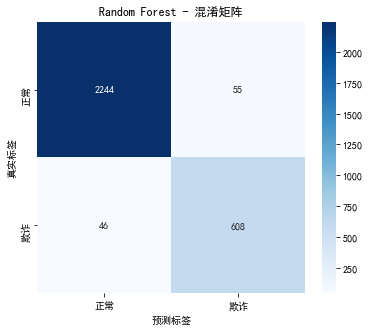


--- Logistic Regression ---
ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      2299
           1       0.35      0.86      0.50       654

    accuracy                           0.61      2953
   macro avg       0.64      0.70      0.59      2953
weighted avg       0.80      0.61      0.65      2953

AUC Score: 0.844


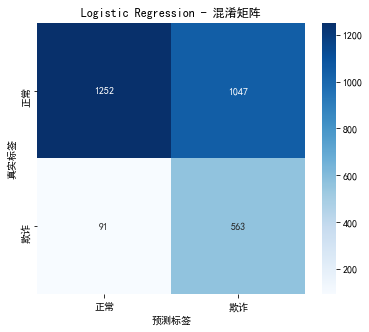


--- XGBoost ---
ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.95      0.94      0.94       654

    accuracy                           0.97      2953
   macro avg       0.96      0.96      0.96      2953
weighted avg       0.97      0.97      0.97      2953

AUC Score: 0.996


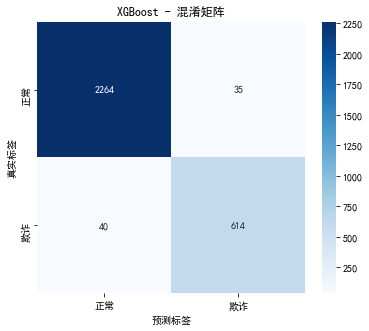


--- LightGBM ---
ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.95      0.95      0.95       654

    accuracy                           0.98      2953
   macro avg       0.96      0.97      0.97      2953
weighted avg       0.98      0.98      0.98      2953

AUC Score: 0.996


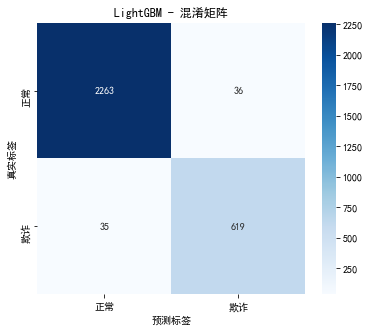


--- Isolation Forest ---
ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      2299
           1       0.08      0.07      0.07       654

    accuracy                           0.60      2953
   macro avg       0.41      0.41      0.41      2953
weighted avg       0.59      0.60      0.60      2953

AUC Score: 0.329


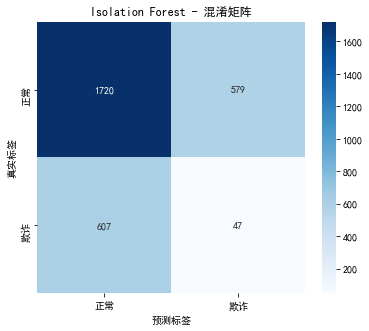

In [38]:
# ============================================================================
# 6. Ê®°ÂûãËØÑ‰º∞
# ============================================================================
print("\n6. Ê®°ÂûãËØÑ‰º∞")

results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    if name == 'Isolation Forest':
        # Â≠§Á´ãÊ£ÆÊûóÁöÑÁâπÊÆäÂ§ÑÁêÜ
        y_pred = model.predict(X_test)
        y_scores = model.decision_function(X_test)
        y_pred_binary = [1 if x == -1 else 0 for x in y_pred]
        
        print("ÂàÜÁ±ªÊä•Âëä:")
        print(classification_report(y_test, y_pred_binary))
        
        y_scores_adjusted = -y_scores
        auc = roc_auc_score(y_test, y_scores_adjusted)
        
        results[name] = {
            'predictions': y_pred_binary,
            'probabilities': y_scores_adjusted,
            'auc': auc
        }
        
    else:
        # ÊúâÁõëÁù£Ê®°Âûã
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        print("ÂàÜÁ±ªÊä•Âëä:")
        print(classification_report(y_test, y_pred))
        
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'auc': auc
        }
    
    print(f"AUC Score: {auc:.3f}")
    
    # ÁªòÂà∂Ê∑∑Ê∑ÜÁü©Èòµ
    cm = confusion_matrix(y_test, results[name]['predictions'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Ê≠£Â∏∏', 'Ê¨∫ËØà'], 
               yticklabels=['Ê≠£Â∏∏', 'Ê¨∫ËØà'])
    plt.title(f'{name} - Ê∑∑Ê∑ÜÁü©Èòµ')
    plt.xlabel('È¢ÑÊµãÊ†áÁ≠æ')
    plt.ylabel('ÁúüÂÆûÊ†áÁ≠æ')
    plt.show()


Ê®°ÂûãÊØîËæÉÂèØËßÜÂåñ...


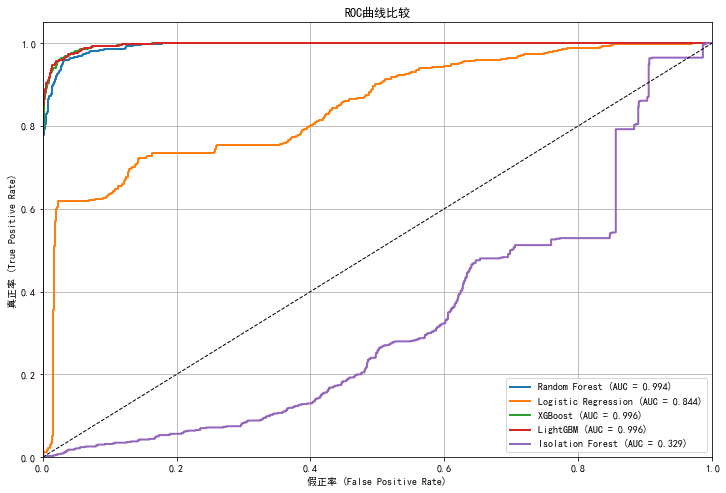

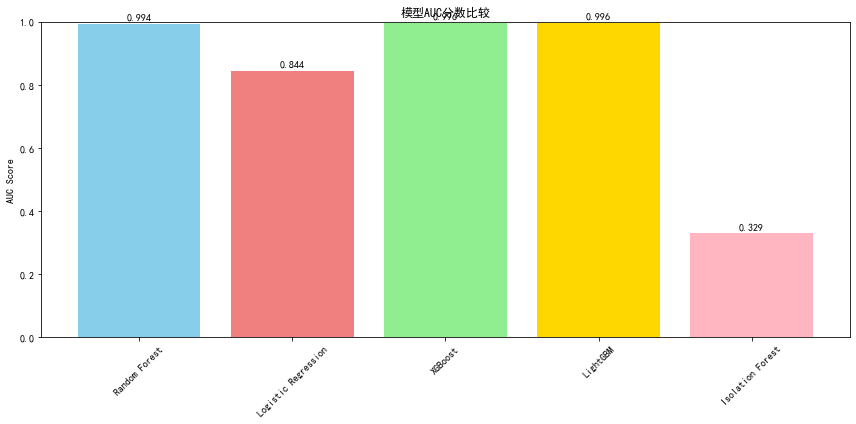

In [39]:
# 6.1 Ê®°ÂûãÊØîËæÉÂèØËßÜÂåñ
print("\nÊ®°ÂûãÊØîËæÉÂèØËßÜÂåñ...")

# ROCÊõ≤Á∫øÊØîËæÉ
plt.figure(figsize=(12, 8))
for name, result in results.items():
    if name == 'Isolation Forest':
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    else:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('ÂÅáÊ≠£Áéá (False Positive Rate)')
plt.ylabel('ÁúüÊ≠£Áéá (True Positive Rate)')
plt.title('ROCÊõ≤Á∫øÊØîËæÉ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# AUCÂàÜÊï∞ÊØîËæÉ
model_names = list(results.keys())
auc_scores = [results[name]['auc'] for name in model_names]

plt.figure(figsize=(12, 6))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']
bars = plt.bar(model_names, auc_scores, color=colors[:len(model_names)])
plt.ylim(0, 1)
plt.ylabel('AUC Score')
plt.title('Ê®°ÂûãAUCÂàÜÊï∞ÊØîËæÉ')

for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


7. ‰∫§ÂèâÈ™åËØÅÊØîËæÉ
ËøõË°å Random Forest ÁöÑ‰∫§ÂèâÈ™åËØÅ...
Random Forest CV AUC: 0.995 (+/- 0.003)
ËøõË°å XGBoost ÁöÑ‰∫§ÂèâÈ™åËØÅ...
XGBoost CV AUC: 0.995 (+/- 0.006)
ËøõË°å LightGBM ÁöÑ‰∫§ÂèâÈ™åËØÅ...
LightGBM CV AUC: 0.996 (+/- 0.003)


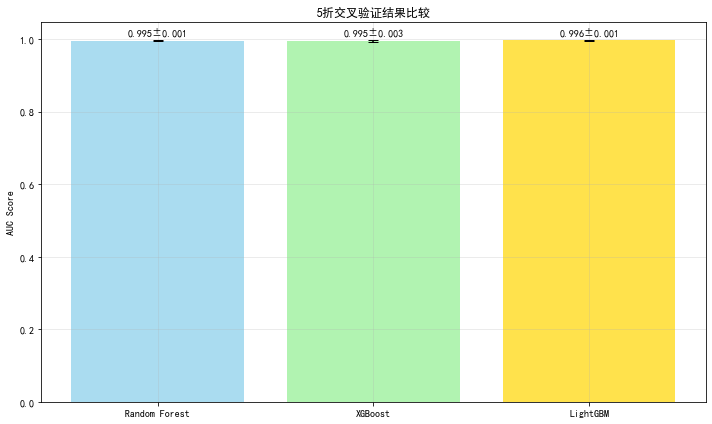

In [41]:
# 7. ‰∫§ÂèâÈ™åËØÅ
print("\n7. ‰∫§ÂèâÈ™åËØÅÊØîËæÉ")

cv_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, 
                               scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=-1, n_jobs=1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in cv_models.items():
    print(f"ËøõË°å {name} ÁöÑ‰∫§ÂèâÈ™åËØÅ...")
    try:
        # Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶ÊúâÊó†Á©∑ÂÄºÊàñNaN
        X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        scores = cross_val_score(model, X_train_clean, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        
        # Ê£ÄÊü•ÂàÜÊï∞ÊòØÂê¶ÊúâÊïà
        if np.all(np.isfinite(scores)) and len(scores) > 0:
            cv_results[name] = scores
            print(f"{name} CV AUC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
        else:
            print(f"{name} ‰∫§ÂèâÈ™åËØÅÂàÜÊï∞Êó†Êïà: {scores}")
            cv_results[name] = np.array([0.5])  # ÈªòËÆ§ÂÄº
            
    except Exception as e:
        print(f"{name} ‰∫§ÂèâÈ™åËØÅÂ§±Ë¥•: {e}")
        cv_results[name] = np.array([0.5])  # ÈªòËÆ§ÂÄº

# Âè™Âú®ÊúâÊúâÊïàÁªìÊûúÊó∂ÁªòÂà∂ÂõæË°®
valid_results = {k: v for k, v in cv_results.items() if np.all(np.isfinite(v)) and len(v) > 0}

if valid_results:
    # ÁªòÂà∂‰∫§ÂèâÈ™åËØÅÁªìÊûú
    plt.figure(figsize=(10, 6))
    models_cv = list(valid_results.keys())
    means = [np.mean(valid_results[model]) for model in models_cv]
    stds = [np.std(valid_results[model]) for model in models_cv]

    x_pos = np.arange(len(models_cv))
    plt.bar(x_pos, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'gold'], alpha=0.7)
    plt.ylabel('AUC Score')
    plt.title('5Êäò‰∫§ÂèâÈ™åËØÅÁªìÊûúÊØîËæÉ')
    plt.xticks(x_pos, models_cv)
    plt.grid(True, alpha=0.3)

    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i, mean + std + 0.01, f'{mean:.3f}¬±{std:.3f}', 
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("Ê≤°ÊúâÊúâÊïàÁöÑ‰∫§ÂèâÈ™åËØÅÁªìÊûúÂèØÂ±ïÁ§∫")


8. ÁâπÂæÅÈáçË¶ÅÊÄßÂàÜÊûê


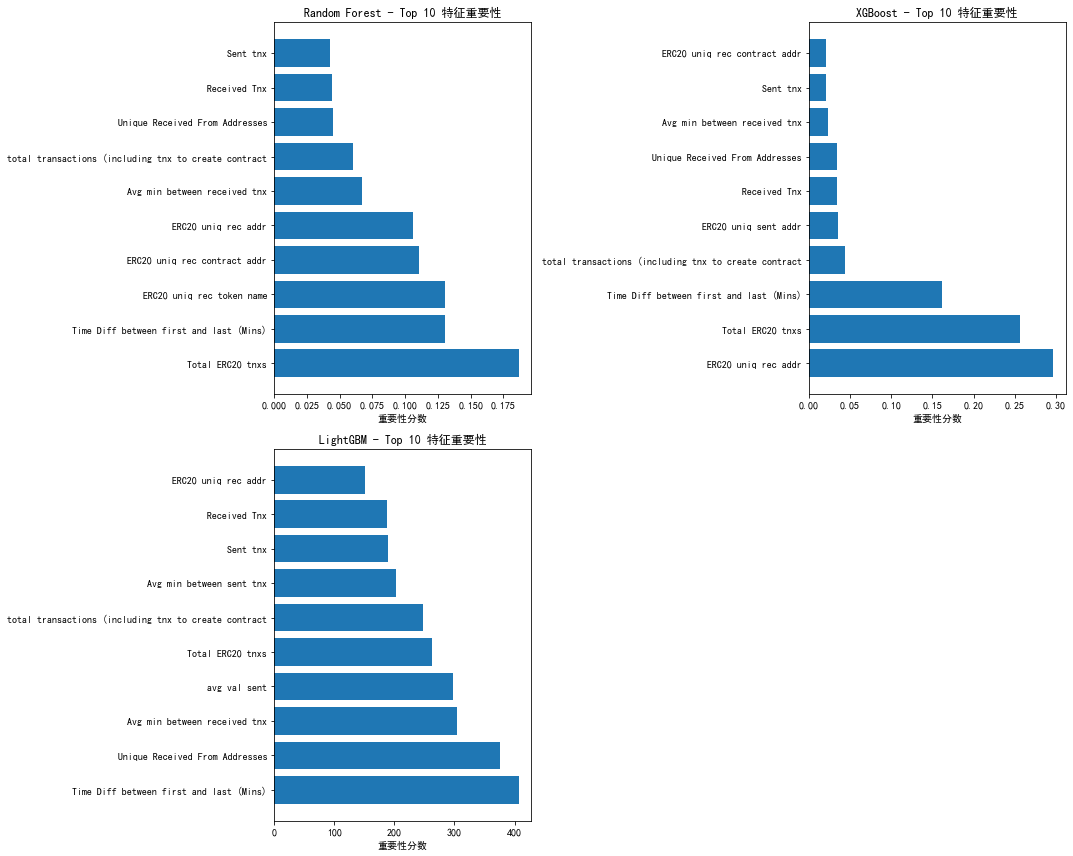


ÂêÑÊ®°ÂûãÊúÄÈáçË¶ÅÁöÑÁâπÂæÅ:
Random Forest:  Total ERC20 tnxs
XGBoost:  ERC20 uniq rec addr
LightGBM: Time Diff between first and last (Mins)


In [42]:
# ============================================================================
# 8. ÁâπÂæÅÈáçË¶ÅÊÄßÂàÜÊûê
# ============================================================================
print("\n8. ÁâπÂæÅÈáçË¶ÅÊÄßÂàÜÊûê")

# Ëé∑ÂèñÂêÑ‰∏™Ê®°ÂûãÁöÑÁâπÂæÅÈáçË¶ÅÊÄß
importance_data = []

for name, model in models.items():
    if name in ['Random Forest', 'XGBoost', 'LightGBM']:
        importance = model.feature_importances_
        for i, (feature, imp) in enumerate(zip(feature_names, importance)):
            importance_data.append({
                'Model': name,
                'Feature': feature,
                'Importance': imp,
                'Rank': i + 1
            })

importance_df = pd.DataFrame(importance_data)

# ÁªòÂà∂ÁâπÂæÅÈáçË¶ÅÊÄßÊØîËæÉÂõæ
top_n = 10
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models_to_plot = ['Random Forest', 'XGBoost', 'LightGBM']

for i, model_name in enumerate(models_to_plot):
    if i < len(axes):
        model_importance = importance_df[importance_df['Model'] == model_name]
        top_features = model_importance.nlargest(top_n, 'Importance')
        
        axes[i].barh(range(len(top_features)), top_features['Importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['Feature'])
        axes[i].set_title(f'{model_name} - Top {top_n} ÁâπÂæÅÈáçË¶ÅÊÄß')
        axes[i].set_xlabel('ÈáçË¶ÅÊÄßÂàÜÊï∞')

# ÁßªÈô§Â§ö‰ΩôÁöÑÂ≠êÂõæ
for i in range(len(models_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("\nÂêÑÊ®°ÂûãÊúÄÈáçË¶ÅÁöÑÁâπÂæÅ:")
for model_name in models_to_plot:
    top_feature = importance_df[importance_df['Model'] == model_name].nlargest(1, 'Importance')
    print(f"{model_name}: {top_feature['Feature'].iloc[0]}")


In [43]:
# ============================================================================
# 9. Ë∂ÖÂèÇÊï∞Ë∞É‰ºò
# ============================================================================
print("\n9. Ë∂ÖÂèÇÊï∞Ë∞É‰ºò")

# XGBoostÂèÇÊï∞Ë∞É‰ºò
print("ËøõË°åXGBoostÂèÇÊï∞Ë∞É‰ºò...")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model_tune = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)

grid_search = GridSearchCV(
    xgb_model_tune, xgb_params, cv=3, scoring='roc_auc', 
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print(f"XGBoostÊúÄ‰Ω≥ÂèÇÊï∞: {grid_search.best_params_}")
print(f"XGBoostÊúÄ‰Ω≥ÂàÜÊï∞: {grid_search.best_score_:.3f}")

# ‰ΩøÁî®ÊúÄ‰Ω≥ÂèÇÊï∞ÈáçÊñ∞ËÆ≠ÁªÉ
best_xgb = grid_search.best_estimator_
models['XGBoost_Tuned'] = best_xgb

# ËØÑ‰º∞Ë∞É‰ºòÂêéÁöÑÊ®°Âûã
y_pred_tuned = best_xgb.predict(X_test)
y_pred_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"Ë∞É‰ºòÂêéXGBoost AUC: {auc_tuned:.3f}")


9. Ë∂ÖÂèÇÊï∞Ë∞É‰ºò
ËøõË°åXGBoostÂèÇÊï∞Ë∞É‰ºò...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoostÊúÄ‰Ω≥ÂèÇÊï∞: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
XGBoostÊúÄ‰Ω≥ÂàÜÊï∞: 0.995
Ë∞É‰ºòÂêéXGBoost AUC: 0.996



10. È£éÈô©ËØÑÂàÜÁ≥ªÁªü


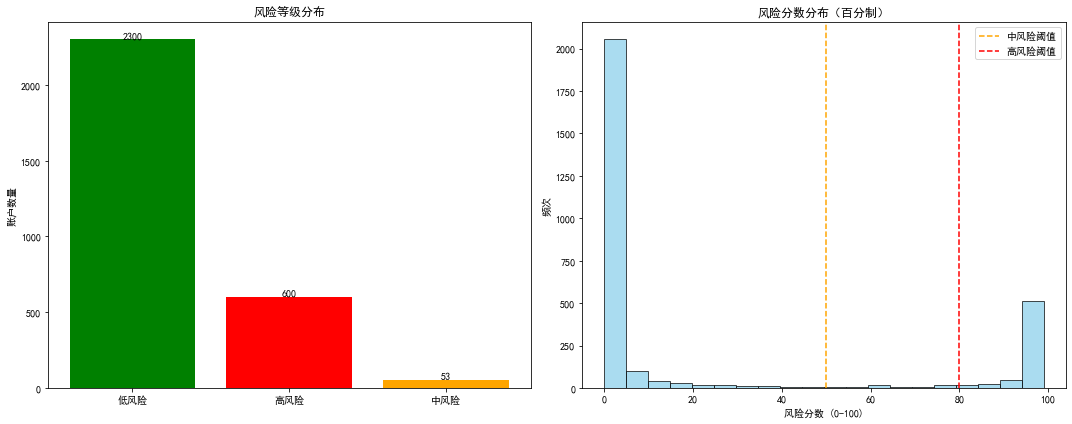


È£éÈô©Á≠âÁ∫ßÂàÜÂ∏É:
  È´òÈ£éÈô©: 600‰∏™Ë¥¶Êà∑ (20.3%)
  ‰∏≠È£éÈô©: 53‰∏™Ë¥¶Êà∑ (1.8%)
  ‰ΩéÈ£éÈô©: 2300‰∏™Ë¥¶Êà∑ (77.9%)

È´òÈ£éÈô©Ë¥¶Êà∑ÂàÜÊûê:
  È´òÈ£éÈô©Ë¥¶Êà∑Êï∞Èáè: 600
  È´òÈ£éÈô©Ë¥¶Êà∑‰∏≠ÁúüÂÆûÊ¨∫ËØàÊØî‰æã: 97.5%

È£éÈô©ÂàÜÊï∞ÁªüËÆ°:
  Âπ≥ÂùáÈ£éÈô©ÂàÜÊï∞: 22.5
  ÊúÄÈ´òÈ£éÈô©ÂàÜÊï∞: 99
  ÊúÄ‰ΩéÈ£éÈô©ÂàÜÊï∞: 0


In [44]:
# ============================================================================
# 10. È£éÈô©ËØÑÂàÜÁ≥ªÁªüÔºàÁôæÂàÜÂà∂Ôºâ
# ============================================================================
print("\n10. È£éÈô©ËØÑÂàÜÁ≥ªÁªü")

# ‰ΩøÁî®ÈõÜÊàêÊ®°ÂûãÁöÑÈ¢ÑÊµãÊ¶ÇÁéá
ensemble_probs = []
for name, model in models.items():
    if name not in ['Isolation Forest', 'Logistic Regression'] and hasattr(model, 'predict_proba'):
        prob = model.predict_proba(X_test)[:, 1]
        ensemble_probs.append(prob)

# Âπ≥ÂùáÊ¶ÇÁéáÂπ∂ËΩ¨Êç¢‰∏∫ÁôæÂàÜÂà∂
final_prob = np.mean(ensemble_probs, axis=0)
risk_scores_percent = (final_prob * 100).astype(int)  # ËΩ¨Êç¢‰∏∫0-100ÁöÑÊï¥Êï∞ÂàÜÊï∞

# ÂàõÂª∫È£éÈô©Á≠âÁ∫ßÔºàÁôæÂàÜÂà∂Ôºâ
def get_risk_level(score):
    if score >= 80:
        return "È´òÈ£éÈô©"
    elif score >= 50:
        return "‰∏≠È£éÈô©"
    else:
        return "‰ΩéÈ£éÈô©"

risk_results = []
for score in risk_scores_percent:
    level = get_risk_level(score)
    risk_results.append({
        'È£éÈô©ÂàÜÊï∞': score,
        'È£éÈô©Á≠âÁ∫ß': level
    })

risk_df = pd.DataFrame(risk_results)
risk_df['ÁúüÂÆûÊ†áÁ≠æ'] = y_test.values

# È£éÈô©ÂàÜÂ∏ÉÂèØËßÜÂåñ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# È£éÈô©Á≠âÁ∫ßÂàÜÂ∏É
risk_counts = risk_df['È£éÈô©Á≠âÁ∫ß'].value_counts()
colors = {'È´òÈ£éÈô©': 'red', '‰∏≠È£éÈô©': 'orange', '‰ΩéÈ£éÈô©': 'green'}
bar_colors = [colors[level] for level in risk_counts.index]

ax1.bar(risk_counts.index, risk_counts.values, color=bar_colors)
ax1.set_title('È£éÈô©Á≠âÁ∫ßÂàÜÂ∏É')
ax1.set_ylabel('Ë¥¶Êà∑Êï∞Èáè')
for i, count in enumerate(risk_counts.values):
    ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

# È£éÈô©ÂàÜÊï∞ÂàÜÂ∏É
ax2.hist(risk_df['È£éÈô©ÂàÜÊï∞'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=50, color='orange', linestyle='--', label='‰∏≠È£éÈô©ÈòàÂÄº')
ax2.axvline(x=80, color='red', linestyle='--', label='È´òÈ£éÈô©ÈòàÂÄº')
ax2.set_title('È£éÈô©ÂàÜÊï∞ÂàÜÂ∏ÉÔºàÁôæÂàÜÂà∂Ôºâ')
ax2.set_xlabel('È£éÈô©ÂàÜÊï∞ (0-100)')
ax2.set_ylabel('È¢ëÊ¨°')
ax2.legend()

plt.tight_layout()
plt.show()

# È£éÈô©ÂàÜÊûê
print("\nÈ£éÈô©Á≠âÁ∫ßÂàÜÂ∏É:")
for level in ['È´òÈ£éÈô©', '‰∏≠È£éÈô©', '‰ΩéÈ£éÈô©']:
    count = len(risk_df[risk_df['È£éÈô©Á≠âÁ∫ß'] == level])
    percentage = count / len(risk_df) * 100
    print(f"  {level}: {count}‰∏™Ë¥¶Êà∑ ({percentage:.1f}%)")

high_risk_accounts = risk_df[risk_df['È£éÈô©Á≠âÁ∫ß'] == 'È´òÈ£éÈô©']
if len(high_risk_accounts) > 0:
    accuracy = high_risk_accounts['ÁúüÂÆûÊ†áÁ≠æ'].mean() * 100
    print(f"\nÈ´òÈ£éÈô©Ë¥¶Êà∑ÂàÜÊûê:")
    print(f"  È´òÈ£éÈô©Ë¥¶Êà∑Êï∞Èáè: {len(high_risk_accounts)}")
    print(f"  È´òÈ£éÈô©Ë¥¶Êà∑‰∏≠ÁúüÂÆûÊ¨∫ËØàÊØî‰æã: {accuracy:.1f}%")

# ÊòæÁ§∫È£éÈô©ÂàÜÊï∞ÁªüËÆ°
print(f"\nÈ£éÈô©ÂàÜÊï∞ÁªüËÆ°:")
print(f"  Âπ≥ÂùáÈ£éÈô©ÂàÜÊï∞: {risk_df['È£éÈô©ÂàÜÊï∞'].mean():.1f}")
print(f"  ÊúÄÈ´òÈ£éÈô©ÂàÜÊï∞: {risk_df['È£éÈô©ÂàÜÊï∞'].max()}")
print(f"  ÊúÄ‰ΩéÈ£éÈô©ÂàÜÊï∞: {risk_df['È£éÈô©ÂàÜÊï∞'].min()}")

In [46]:
# ============================================================================
# 11. ÂçïÊ†∑Êú¨È¢ÑÊµãÂíå‰∏öÂä°Â∫îÁî®
# ============================================================================
print("\n11. ÂçïÊ†∑Êú¨È¢ÑÊµãÁ§∫‰æã")

# ÈÄâÊã©Âá†‰∏™ÊµãËØïÊ†∑Êú¨ËøõË°åËØ¶ÁªÜÂàÜÊûê
sample_indices = [0, 1, 2]
best_model_name = max(results, key=lambda x: results[x]['auc'] if x != 'Isolation Forest' else 0)
best_model = models[best_model_name]

print(f"‰ΩøÁî®ÊúÄ‰Ω≥Ê®°Âûã: {best_model_name}")

# ÂÆö‰πâÈ£éÈô©Á≠âÁ∫ßÂáΩÊï∞Ôºà‰∏éÂâçÈù¢‰∏ÄËá¥Ôºâ
def get_risk_level_percent(score):
    """ÁôæÂàÜÂà∂È£éÈô©Á≠âÁ∫ßÂà§Êñ≠"""
    if score >= 80:
        return "È´òÈ£éÈô©", "Á´ãÂç≥ÂÜªÁªìÂπ∂Ë∞ÉÊü•"
    elif score >= 50:
        return "‰∏≠È£éÈô©", "Âä†Âº∫ÁõëÊéß"
    else:
        return "‰ΩéÈ£éÈô©", "Ê≠£Â∏∏Â§ÑÁêÜ"

for idx in sample_indices:
    sample_features = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    
    if hasattr(best_model, 'predict_proba'):
        prediction_prob = best_model.predict_proba([sample_features])[0][1]
        risk_score = int(prediction_prob * 100)  # ËΩ¨Êç¢‰∏∫ÁôæÂàÜÂà∂
    else:
        # ÂØπ‰∫éÂ≠§Á´ãÊ£ÆÊûó
        score = best_model.decision_function([sample_features])[0]
        risk_score = int(max(0, min(100, (1 - score) * 50)))  # ËΩ¨Êç¢‰∏∫0-100ÂàÜÊï∞
    
    level, action = get_risk_level_percent(risk_score)
    
    print(f"\nÊ†∑Êú¨ {idx} ÂàÜÊûê:")
    print(f"  È£éÈô©ÂàÜÊï∞: {risk_score}ÂàÜ")
    print(f"  È£éÈô©Á≠âÁ∫ß: {level}")
    print(f"  Âª∫ËÆÆÊé™ÊñΩ: {action}")
    print(f"  ÁúüÂÆûÊ†áÁ≠æ: {'Ê¨∫ËØà' if true_label == 1 else 'Ê≠£Â∏∏'}")
    
    # ÊòæÁ§∫ÊúÄÈáçË¶ÅÁöÑÁâπÂæÅÂÄº
    if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        importance = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(3)
        
        print("  ÂÖ≥ÈîÆÁâπÂæÅÂÄº:")
        for _, row in feature_importance_df.iterrows():
            feature = row['feature']
            value = sample_features[feature]
            print(f"    {feature}: {value:.3f}")


11. ÂçïÊ†∑Êú¨È¢ÑÊµãÁ§∫‰æã
‰ΩøÁî®ÊúÄ‰Ω≥Ê®°Âûã: LightGBM

Ê†∑Êú¨ 0 ÂàÜÊûê:
  È£éÈô©ÂàÜÊï∞: 99ÂàÜ
  È£éÈô©Á≠âÁ∫ß: È´òÈ£éÈô©
  Âª∫ËÆÆÊé™ÊñΩ: Á´ãÂç≥ÂÜªÁªìÂπ∂Ë∞ÉÊü•
  ÁúüÂÆûÊ†áÁ≠æ: Ê¨∫ËØà
  ÂÖ≥ÈîÆÁâπÂæÅÂÄº:
    Time Diff between first and last (Mins): -0.676
    Unique Received From Addresses: -0.102
    Avg min between received tnx: -0.347

Ê†∑Êú¨ 1 ÂàÜÊûê:
  È£éÈô©ÂàÜÊï∞: 0ÂàÜ
  È£éÈô©Á≠âÁ∫ß: ‰ΩéÈ£éÈô©
  Âª∫ËÆÆÊé™ÊñΩ: Ê≠£Â∏∏Â§ÑÁêÜ
  ÁúüÂÆûÊ†áÁ≠æ: Ê≠£Â∏∏
  ÂÖ≥ÈîÆÁâπÂæÅÂÄº:
    Time Diff between first and last (Mins): -0.676
    Unique Received From Addresses: -0.098
    Avg min between received tnx: -0.347

Ê†∑Êú¨ 2 ÂàÜÊûê:
  È£éÈô©ÂàÜÊï∞: 0ÂàÜ
  È£éÈô©Á≠âÁ∫ß: ‰ΩéÈ£éÈô©
  Âª∫ËÆÆÊé™ÊñΩ: Ê≠£Â∏∏Â§ÑÁêÜ
  ÁúüÂÆûÊ†áÁ≠æ: Ê≠£Â∏∏
  ÂÖ≥ÈîÆÁâπÂæÅÂÄº:
    Time Diff between first and last (Mins): 0.907
    Unique Received From Addresses: -0.092
    Avg min between received tnx: 1.519


In [47]:
# ============================================================================
# 12. ÁªìÊûúÊÄªÁªì
# ============================================================================
print("\n" + "="*50)
print("ÂàÜÊûêÊÄªÁªì")
print("="*50)

# ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã
best_supervised_model = max([(name, results[name]['auc']) for name in results if name != 'Isolation Forest'], 
                           key=lambda x: x[1])

print(f"ÊúÄ‰Ω≥ÁõëÁù£Ê®°Âûã: {best_supervised_model[0]} (AUC = {best_supervised_model[1]:.3f})")

# Ê®°ÂûãÊÄßËÉΩÊéíÂêç
print("\nÊ®°ÂûãÊÄßËÉΩÊéíÂêç:")
sorted_models = sorted([(name, results[name]['auc']) for name in results], 
                      key=lambda x: x[1], reverse=True)
for i, (name, auc) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: {auc:.3f}")

# ‰∏öÂä°Âª∫ËÆÆ
print(f"\n‰∏öÂä°Âª∫ËÆÆ:")
print(f"- Êé®Ëçê‰ΩøÁî® {best_supervised_model[0]} Ê®°ÂûãËøõË°åÁîü‰∫ßÁéØÂ¢ÉÈÉ®ÁΩ≤")
print(f"- È´òÈ£éÈô©ÈòàÂÄºÂª∫ËÆÆËÆæÁΩÆ‰∏∫ 0.7")
print(f"- ÂΩìÂâçÊ£ÄÊµãÂáÜÁ°ÆÁéá: {results[best_supervised_model[0]]['auc']:.1%}")

print("\n=== ÂàÜÊûêÂÆåÊàê! ===")


ÂàÜÊûêÊÄªÁªì
ÊúÄ‰Ω≥ÁõëÁù£Ê®°Âûã: LightGBM (AUC = 0.996)

Ê®°ÂûãÊÄßËÉΩÊéíÂêç:
1. LightGBM: 0.996
2. XGBoost: 0.996
3. Random Forest: 0.994
4. Logistic Regression: 0.844
5. Isolation Forest: 0.329

‰∏öÂä°Âª∫ËÆÆ:
- Êé®Ëçê‰ΩøÁî® LightGBM Ê®°ÂûãËøõË°åÁîü‰∫ßÁéØÂ¢ÉÈÉ®ÁΩ≤
- È´òÈ£éÈô©ÈòàÂÄºÂª∫ËÆÆËÆæÁΩÆ‰∏∫ 0.7
- ÂΩìÂâçÊ£ÄÊµãÂáÜÁ°ÆÁéá: 99.6%

=== ÂàÜÊûêÂÆåÊàê! ===


In [48]:
# ============================================================================
# 12. Ê®°Âûã‰øùÂ≠ò
# ============================================================================
print("\n12. Ê®°Âûã‰øùÂ≠ò")

import os
import joblib

# ÂàõÂª∫Ê®°Âûã‰øùÂ≠òÁõÆÂΩï
model_dir = "model_serving/models"
os.makedirs(model_dir, exist_ok=True)

# ‰øùÂ≠òLightGBMÊ®°Âûã
if 'LightGBM' in models:
    try:
        lgb_model_path = os.path.join(model_dir, "lgb_v2025.pkl")
        joblib.dump(models['LightGBM'], lgb_model_path)
        print(f"LightGBMÊ®°ÂûãÂ∑≤‰øùÂ≠òÂà∞: {lgb_model_path}")
    except Exception as e:
        print(f"LightGBMÊ®°Âûã‰øùÂ≠òÂ§±Ë¥•: {e}")

# ‰øùÂ≠òÂÖ∂‰ªñÈáçË¶ÅÊ®°ÂûãÂíåÁªÑ‰ª∂
try:
    # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
    best_model_name = max(results, key=lambda x: results[x]['auc'] if x != 'Isolation Forest' else 0)
    best_model_path = os.path.join(model_dir, f"best_model_{best_model_name}.pkl")
    joblib.dump(models[best_model_name], best_model_path)
    print(f"ÊúÄ‰Ω≥Ê®°Âûã({best_model_name})Â∑≤‰øùÂ≠òÂà∞: {best_model_path}")
    
    # ‰øùÂ≠òÊ†áÂáÜÂåñÂô®
    scaler_path = os.path.join(model_dir, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"Ê†áÂáÜÂåñÂô®Â∑≤‰øùÂ≠òÂà∞: {scaler_path}")
    
    # ‰øùÂ≠òÁâπÂæÅÂêçÁß∞
    feature_names_path = os.path.join(model_dir, "feature_names.pkl")
    joblib.dump(feature_names, feature_names_path)
    print(f"ÁâπÂæÅÂêçÁß∞Â∑≤‰øùÂ≠òÂà∞: {feature_names_path}")
    
except Exception as e:
    print(f"Ê®°Âûã‰øùÂ≠òËøáÁ®ã‰∏≠Âá∫Èîô: {e}")

print("Ê®°Âûã‰øùÂ≠òÂÆåÊàê!")


12. Ê®°Âûã‰øùÂ≠ò
LightGBMÊ®°ÂûãÂ∑≤‰øùÂ≠òÂà∞: model_serving/models\lgb_v2025.pkl
ÊúÄ‰Ω≥Ê®°Âûã(LightGBM)Â∑≤‰øùÂ≠òÂà∞: model_serving/models\best_model_LightGBM.pkl
Ê†áÂáÜÂåñÂô®Â∑≤‰øùÂ≠òÂà∞: model_serving/models\scaler.pkl
ÁâπÂæÅÂêçÁß∞Â∑≤‰øùÂ≠òÂà∞: model_serving/models\feature_names.pkl
Ê®°Âûã‰øùÂ≠òÂÆåÊàê!


In [49]:
# check_model_file.py
import pickle
import os

def check_model_file(file_path):
    """Ê£ÄÊü•Ê®°ÂûãÊñá‰ª∂ÊòØÂê¶ÊúâÊïà"""
    print(f"üîç Ê£ÄÊü•Êñá‰ª∂: {file_path}")
    
    # Ê£ÄÊü•Êñá‰ª∂Â§ßÂ∞è
    file_size = os.path.getsize(file_path)
    print(f"üìÅ Êñá‰ª∂Â§ßÂ∞è: {file_size} Â≠óËäÇ")
    
    if file_size == 0:
        print("‚ùå Êñá‰ª∂‰∏∫Á©∫!")
        return False
    
    # Â∞ùËØïËØªÂèñÊñá‰ª∂
    try:
        with open(file_path, 'rb') as f:
            # ÂÖàËØªÂèñÊñá‰ª∂Â§¥ÁúãÁúã
            header = f.read(100)
            print(f"üìÑ Êñá‰ª∂Â§¥: {header[:20]}...")
            
            # Ê£ÄÊü•ÊòØÂê¶ÊòØpickleÊñá‰ª∂
            if header.startswith(b'\x80'):  # pickleÊñá‰ª∂ÈÄöÂ∏∏‰ª•Ëøô‰∏™ÂºÄÂ§¥
                print("‚úÖ Êñá‰ª∂ÊòØÊúâÊïàÁöÑpickleÊ†ºÂºè")
            else:
                print("‚ùå Êñá‰ª∂‰∏çÊòØÊúâÊïàÁöÑpickleÊ†ºÂºè")
                return False
                
    except Exception as e:
        print(f"‚ùå Êñá‰ª∂ËØªÂèñÂ§±Ë¥•: {e}")
        return False
    
    return True

# Ê£ÄÊü•Ê®°ÂûãÊñá‰ª∂
check_model_file("model_serving/models/lgb_v2025.pkl")

üîç Ê£ÄÊü•Êñá‰ª∂: model_serving/models/lgb_v2025.pkl
üìÅ Êñá‰ª∂Â§ßÂ∞è: 350100 Â≠óËäÇ
üìÑ Êñá‰ª∂Â§¥: b'\x80\x03clightgbm.sklearn\n'...
‚úÖ Êñá‰ª∂ÊòØÊúâÊïàÁöÑpickleÊ†ºÂºè


True